<a href="https://colab.research.google.com/github/Kaybhee/model_deployment/blob/main/imgSynthesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing Necessary libraries

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras import datasets
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,Reshape,UpSampling2D, LeakyReLU, Dropout
import tensorflow_datasets as tfds


Describing the Data

In [8]:
data_set = tfds.load("fashion_mnist", split = "train")
data_iterator = data_set.as_numpy_iterator()
data_iterator.next().keys()


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/incomplete.JVB0I7_3.0.1/fashion_mnist-train.tfrecord*...:   …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/incomplete.JVB0I7_3.0.1/fashion_mnist-test.tfrecord*...:   0…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


dict_keys(['image', 'label'])

### Visualizing Dataset


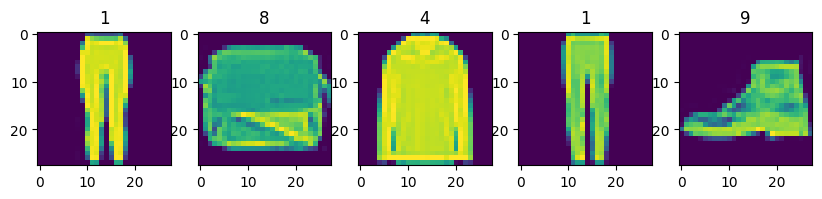

In [9]:
fig, axes = plt.subplots(ncols = 5, figsize = (10,10))
for index in range(5):
  data = data_iterator.next()
  # data = data_set.as_numpy_iterator().next()['image']
  axes[index].imshow(np.squeeze(data['image']))
  axes[index].set_title(data['label'])

### Function to scale Images

In [10]:
def scale(data):
  images = data['image'] / 255
  return images

In [11]:
data_set = tfds.load("fashion_mnist", split = "train")
# map
ds = data_set.map(scale)
# Cache
ds.cache()
# Shuffle
ds.shuffle(60000)
# Batch
ds.batch(128)
# Prefetch
ds.prefetch(64)

ds.as_numpy_iterator().next().shape



(28, 28, 1)

Building a Generator

In [12]:
def build_generator():
  model = Sequential()
  model.add(Dense(7*7*128, input_dim = 128))
  model.add(LeakyReLU(0.2))
  model.add(Reshape((7,7,128)))
  #  Upsampling block
  model.add(UpSampling2D())
  model.add(Conv2D(128, kernel_size = 5, padding = "same"))
  model.add(LeakyReLU(0.2))
  #
  model.add(UpSampling2D())
  model.add(Conv2D(128, kernel_size= 5, padding = "same"))
  model.add(LeakyReLU(0.2))
  # Convolutional blocks to obtain parameters for the model to learn
  # Adding more layers for the model to learn from
  model.add(Conv2D(128, kernel_size = 4, padding = "same"))
  model.add(LeakyReLU(0.2))
  # Convolutional blocks
  model.add(Conv2D(128, kernel_size = 4, padding = "same"))
  model.add(LeakyReLU(0.2))

  # output layer
  model.add(Conv2D(1, kernel_size = 4, activation = "sigmoid", padding = "same"))
  # model.add(UpSampling2D)
  # model.add(Conv2D)

  return model


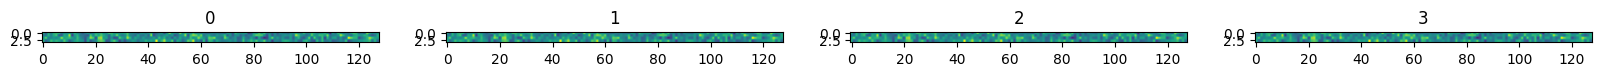

In [13]:
images = np.random.randn(4, 128, 1)
# images.shape
fig, axes = plt.subplots(ncols = 4, figsize = (20, 20))
for index, img in enumerate(images):
  axes[index].imshow(np.squeeze(images))
  axes[index].set_title(index)

### Building a discriminator


In [14]:
def discriminator():
  model = Sequential()
  model.add(Conv2D(32, 5,input_shape = (28,28,1)))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))
  # Another block
  model.add(Conv2D(64, 5))
  model.add(Dropout(0.4))
  # 3rd block
  model.add(Conv2D(128,5))
  model.add(Dropout(0.4))
  #  Fifth block
  model.add(Conv2D(256, 5))
  model.add(Dropout(0.4))

# Flattening the layer
  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1, activation = "sigmoid"))

  return model

In [26]:
generator = build_generator()
generator.summary()
image = generator.predict(np.random.randn(4, 128,1))
image

(X_train, y_train), (X_test, y_test) = datasets.fashion_mnist.load_data()
(X_train.shape, y_train.shape), (X_test.shape, y_test.shape)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                      │ (None, 6272)                │         809,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_29 (LeakyReLU)           │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_5 (Reshape)                  │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_10 (UpSampling2D)      │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_41 (Conv2D)                   │ (None, 14, 14, 128)         │         409,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_30 (LeakyReLU)           │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_11 (UpSampling2D)      │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_42 (Conv2D)                   │ (None, 28, 28, 128)         │         409,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_31 (LeakyReLU)           │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_43 (Conv2D)                   │ (None, 28, 28, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_32 (LeakyReLU)           │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_44 (Conv2D)                   │ (None, 28, 28, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_33 (LeakyReLU)           │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_45 (Conv2D)                   │ (None, 28, 28, 1)           │           2,049 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,155,137 (8.22 MB)

 Trainable params: 2,155,137 (8.22 MB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step


(((60000, 28, 28), (60000,)), ((10000, 28, 28), (10000,)))

In [16]:
disc_model = discriminator()
disc_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 24, 24, 32)          │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 20, 20, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 20, 20, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 16, 16, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 12, 12, 256)         │         819,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36864)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 36864)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │          36,865 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,113,345 (4.25 MB)

 Trainable params: 1,113,345 (4.25 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
image.shape
# discriminator.predict(images)
disc_model.predict(image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


array([[0.5009722 ],
       [0.5004864 ],
       [0.50098443],
       [0.5001869 ]], dtype=float32)

### Construct Training Loop


In [18]:
g_opt = Adam(learning_rate = 0.0001)
d_opt = Adam(learning_rate =  0.00001)  # The discriminator made slower than our generator so it doesn't out perform the generator
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

### Building Subclass model


In [23]:
from tensorflow.keras import Model
class FashionGAN(Model):
  def __init__(self, generator, discriminator, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.generator = generator
    self.discriminator = discriminator

  def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
    # .compile(optimizer = 'Adam', loss = BinaryCrossentropy, metrics =[ 'Accuracy'])
    super().compile()
    self.g_opt = g_opt
    self.d_opt = d_opt
    self.g_loss = g_loss
    self.d_loss = d_loss
    pass

  def train_step(self, batch):
    real_images = batch
    fake_images = self.generator(tf.random.normal(128,128,1), training = False)


    with tf.GradientTape() as d_tape:
      y_real = self.discriminator(real_images, training = True)
      y_fake = self.discriminator(fake_images, training = True)
      ydiscrim_realfake = tf.concat([y_real,y_fake], axis = 0)

      # Creating labels for the nn
      y_realfake_labels = tf.concat([tf.zeros_like(y_real), tf.ones_like(y_fake)])

      # trying to trick the discriminator with Noise
      noise_real = 0.15 * tf.random.uniform(tf.shape(real_images))
      noise_fake = -0.15 * tf.random.uniform(tf.shape(fake_images))
      y_realfake_labels += tf.concat([noise_real, noise_fake], axis = 0)

      # Introducing Losses - BinaryCrossEntropy(T)
      total_d_loss = self.d_loss(y_realfake_labels, ydiscrim_realfake)
    d_gad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
    # def test_step(): This is only used when we want to use for evaluation
    self.d_opt.apply_gradient(zip(d_gad, self.discriminator.trainable_variables))
    # pass
# Creating a Generator
    with tf.GradientTape() as g_tape:
      gen_images = self.generator(tf.random.normal(128, 128, 1), training = True)
      pred_labels = self.discriminator(gen_images, training = False)
      # We need to trick the discriminator
      total_g_loss = self.g_loss(tf.zeros_like(pred_labels), pred_labels)

    gen_grad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
    self.g_opt.apply_gradients(zip(gen_grad, self.generator.trainable_variables))
    return {"d_loss": total_d_loss, "g_loss": total_g_loss}
# disc_model = discriminator()
# generator = build_generator()


In [27]:
gan = FashionGAN(generator, disc_model)
gan.compile(g_opt, d_opt, g_loss, d_loss)
